In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import skimage
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision import transforms as tr
from torchvision.io import read_image
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
data_folder = "./RGBaHa(26-03-23)"
images_folder = "RGBaHa"
table_file = "data.csv"

In [4]:
target_columns = ["latin", "hgt", "w", "dbh"]

In [5]:
class TreeDataset(Dataset):
    def __init__(self, imgs_path, table_path):
        super().__init__()
        
        self.table = pd.read_csv(table_path, index_col=0).dropna()
        self.label_map = {label: i for i, label in enumerate(self.table.latin.unique())}
        self.table = self.table.replace({"latin": self.label_map})
        
        self.max_h, self.max_w = 0, 0
        self.channel_mean, self.channel_std = 0, 0
        self.depth_max = 0
        images = []
        for tree_id in self.table.treeID:
            file_path = os.path.join(imgs_path, f"treeID_{tree_id}.tiff")
            img_rgbd = skimage.io.imread(file_path)[:, :, [0, 1, 2, 4]].transpose(2, 0, 1)[None, :, :, :]
            self.max_h = max(self.max_h, img_rgbd.shape[2])
            self.max_w = max(self.max_w, img_rgbd.shape[3])
            images.append(torch.from_numpy(img_rgbd))
            self.depth_max = max(self.depth_max, img_rgbd[:, 3, :, :].max())
        
        padded_images = []
        rng = np.random.default_rng()
        for image in images:
            img_h, img_w = image.shape[2:]
            h_pos = rng.integers(0, self.max_h - img_h + 1)
            w_pos = rng.integers(0, self.max_w - img_w + 1)
            padded = torch.zeros(1, 4, self.max_h, self.max_w)
            padded[:, :, h_pos: h_pos+img_h, w_pos: w_pos+img_w] = image
            padded_images.append(padded)
            
            image[:, :3, :, :] /= 255.
            image[:, 3, :, :] /= self.depth_max
            self.channel_mean += image.mean(dim=(0, 2, 3))
            self.channel_std += image.std(dim=(0, 2, 3))

        self.images = torch.cat(padded_images)
        
    def __getitem__(self, index):
        x = self.images[index].type(torch.FloatTensor)
        y_clf = torch.tensor(self.table.iloc[index].loc[target_columns[0]])
        y_regr = torch.tensor(self.table.iloc[index].loc[target_columns[1:]].values)
        return x, y_clf, y_regr
    
    def __len__(self):
        return len(self.table)

In [6]:
class TreeDatasetFromSubset(Dataset):
    def __init__(self, subset, all_transform=None, rgb_only_transform=None):
        self.subset = subset
        self.all_transform = all_transform
        self.rgb_transform = rgb_only_transform

    def __getitem__(self, index):
        x, y_clf, y_regr = self.subset[index]
        if self.all_transform:
            x = self.all_transform(x)
        if self.rgb_transform:
            x[:3, :, :] = self.rgb_transform(x[:3, :, :])
        return x.type(torch.float), y_clf.type(torch.LongTensor), y_regr.type(torch.float)

    def __len__(self):
        return len(self.subset)

In [7]:
data = TreeDataset(os.path.join(data_folder, images_folder), os.path.join(data_folder, table_file))

In [8]:
train, val, test = random_split(data, [0.70, 0.20, 0.10])

In [9]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [10]:
augment_transform = tr.Compose([
    tr.Normalize(data.channel_mean, data.channel_std),
    tr.RandomApply([AddGaussianNoise()]),
    tr.RandomHorizontalFlip(),
    tr.RandomVerticalFlip(),
    # tr.RandomRotation(degrees=180),
    tr.RandomAffine(degrees=180, translate=(0.3, 0.4), scale=(0.4, 0.8)),
    # tr.RandomPerspective()
    
])

augment_rgb_transform = tr.Compose([
    tr.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    tr.RandomAdjustSharpness(0.5),
    tr.RandomAutocontrast(),
])

prepare_transform = tr.Compose([
    tr.Normalize(data.channel_mean, data.channel_std),
])

In [11]:
train_dataset = TreeDatasetFromSubset(train, augment_transform, augment_rgb_transform)
val_dataset = TreeDatasetFromSubset(val, prepare_transform)

Targets:
(tensor(4), tensor([15.4000, 10.1500, 37.2423]))


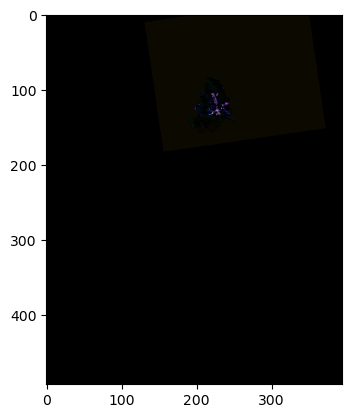

In [12]:
print("Targets:")
print(train_dataset[np.random.randint(0, 100)][1:])
plt.imshow(train_dataset[np.random.randint(0, 100)][0][:3, :, :].movedim(0, -1))
plt.show()

In [13]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
)

In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        stride = (2, 2) if in_channels != out_channels else (1, 1)

        self.shortcut = nn.Identity()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, (1, 1), stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.activation = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, (3, 3), stride, padding=(1, 1), bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, (3, 3), padding=(1, 1), bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        residual = self.shortcut(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)

        return x + residual


class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.blocks = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(out_channels, out_channels)
        )
        
    def forward(self, x):
        x = self.blocks(x)
        return x

In [15]:
class ResNet18(nn.Module):
    def __init__(self, out_channels=32, layer_num=3, fc_clf_hidden=128, fc_regr_hidden=128, in_channels=4, classes_num=len(data.label_map)):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, (3, 3), padding=(1, 1), bias=True)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d((2, 2))
        self.layers = nn.Sequential(
            ResNetLayer(out_channels, out_channels),
            *[ResNetLayer(2**i * out_channels, 2**(i+1) * out_channels) for i in range(layer_num - 1)],
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        
        # predicting tree species
        self.fc_clf = nn.Sequential(
            nn.Linear(2**(layer_num - 1) * out_channels, fc_clf_hidden),
            nn.BatchNorm1d(fc_clf_hidden),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(fc_clf_hidden, classes_num),
            nn.LogSoftmax(dim=1),
        )
        
        # predicting main characteristics
        self.fc_regr = nn.Sequential(
            nn.Linear(2**(layer_num - 1) * out_channels, fc_regr_hidden),
            nn.BatchNorm1d(fc_regr_hidden),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(fc_regr_hidden, len(target_columns[1:])),
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.maxpool(x)
        
        x = self.layers(x)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        x_clf = self.fc_clf(x)
        x_regr = self.fc_regr(x)

        return x_clf, x_regr

In [16]:
import IPython
from math import ceil


def train_loop(model, dataloader, loss_clf_fn, loss_regr_fn, optimizer, step=0.05, history_loss=None, history_acc=None):
    out = display(IPython.display.Pretty('Learning...'), display_id=True)

    size = len(dataloader.dataset)
    batches = ceil(size / dataloader.batch_size) - 1
    
    train_acc = []
    train_loss = []
    percentage = 0
    
    for batch, (X, y_clf, y_regr) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
        torch.cuda.empty_cache()
        gc.collect()
        
        X = X.to(device)
        y_clf = y_clf.to(device)
        y_regr = y_regr.to(device)

        pred_clf, pred_regr = model(X)
        
        loss_clf = loss_clf_fn(pred_clf, y_clf)
        loss_regr = loss_regr_fn(pred_regr, y_regr)
        loss = 100*loss_clf + loss_regr.mean()
        
        train_acc.append((pred_clf.argmax(1) == y_clf).type(torch.float).mean().item())
        train_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch / (batches - 1) >= percentage:
            percentage = int(batch / (batches - 1) / step) * step
            out.update(f'[{int(percentage * size)}/{size}] Loss: {loss:>8f}')
        
    if history_loss is not None:
        history_loss.append([loss_clf.item(), *torch.sqrt(loss_regr.mean(dim=0)).tolist()])
    if history_acc is not None:
        history_acc.append(np.mean(train_acc))

    return {'train_loss': np.mean(train_loss), 'train_acc': np.mean(train_acc)}

def test_loop(model, dataloader,  loss_clf_fn, loss_regr_fn, history_loss=None, history_acc=None):
    size = len(dataloader.dataset)
    test_loss = 0
    batches = ceil(size / dataloader.batch_size)

    val_acc = []
    val_loss = []
    correct = 0

    with torch.no_grad():
        for batch, (X, y_clf, y_regr) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
            torch.cuda.empty_cache()
            gc.collect()
        
            X = X.to(device)
            y_clf = y_clf.to(device)
            y_regr = y_regr.to(device)

            pred_clf, pred_regr = model(X)
            loss_clf = loss_clf_fn(pred_clf, y_clf)
            loss_regr = loss_regr_fn(pred_regr, y_regr)
            loss = 100*loss_clf + loss_regr.mean()
            
            val_acc.append((pred_clf.argmax(1) == y_clf).type(torch.float).mean().item())
            val_loss.append(loss.item())
            
            test_loss += loss.item()
            correct += (pred_clf.argmax(1) == y_clf).type(torch.float).sum().item()

    test_loss /= batches
    correct /= size
    print(f"Validation accuracy: {(100*correct):>0.1f}%, Validation loss: {test_loss:>8f} \n")

    if history_loss is not None:
        history_loss.append([loss_clf.item(), *torch.sqrt(loss_regr.mean(dim=0)).tolist()])
    if history_acc is not None:
        history_acc.append(np.mean(val_acc))
    
    return {'val_loss': np.mean(val_loss), 'val_acc': np.mean(val_acc)}

In [17]:
def plot_learning_process(train_loss, val_loss, title):
    
    fig = plt.figure(figsize=(12, 4))
    
    ax1 = plt.subplot(121)
    ax1.plot(np.arange(0, len(train_loss)) + 1, train_loss, label='train')
    ax1.plot(np.arange(0, len(val_loss)) + 1, val_loss, label='val')
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel('epoch')
    ax1.set_ylabel(title.split()[0])
    ax1.set_title(title)
    
    fig.tight_layout()
    plt.show()

In [ ]:
loss_clf = nn.NLLLoss()
loss_regr = nn.MSELoss(reduction="none")
epochs = 100

models_results = []
for chan in tqdm([16]):
    for layer_n in tqdm([3]):
        net = ResNet18(out_channels=chan, layer_num=layer_n, fc_clf_hidden=128, fc_regr_hidden=128).to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr=2e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.25, patience=5, min_lr=1e-8)
        
        train_acc = []
        val_acc = []
        train_loss = []
        val_loss = []
        
        models_results.append({"first_out_channel": chan, "layer_num": layer_n})
        for epoch in range(epochs):
            # IPython.display.clear_output()
            print(f"Epoch {epoch+1}")
            print("-------------------------------")
            train_loop(net, train_dataloader, loss_clf, loss_regr, optimizer, history_loss=train_loss, history_acc=train_acc)
            test_loop(net, val_dataloader, loss_clf, loss_regr, history_loss=val_loss, history_acc=val_acc)
            scheduler.step(np.sum(val_loss[-1]))

In [21]:
train_loss = np.array(train_loss)
val_loss = np.array(val_loss)

models_results[-1][f"train_{target_columns[0]}_acc"] = train_acc
models_results[-1][f"val_{target_columns[0]}_acc"] = val_acc
for i, target_name in enumerate(target_columns[1:], start=1):
    models_results[-1][f"train_{target_name}_RMSE"] = train_loss[:, i]
    models_results[-1][f"val_{target_name}_RMSE"] = val_loss[:, i]

In [22]:
results_df = pd.DataFrame(models_results)

In [23]:
expanded_df = results_df.set_index(["layer_num"]).apply(pd.Series.explode).reset_index()

expanded_df.index.name = "Epoch"
expanded_df.index = expanded_df.index + 1
expanded_df.dropna()

,layer_num,first_out_channel,train_latin_acc,val_latin_acc,train_hgt_RMSE,val_hgt_RMSE,train_w_RMSE,val_w_RMSE,train_dbh_RMSE,val_dbh_RMSE
Epoch,,,,,,,,,,
1,3,16,0.059028,0.033654,18.403345,17.844826,8.957185,8.509886,40.875481,39.099686
2,3,16,0.076389,0.088141,18.123005,17.669931,9.120648,8.509734,38.346519,39.047161
3,3,16,0.100694,0.153045,18.198946,17.703754,8.903157,8.462464,40.176579,38.896523
4,3,16,0.138889,0.137019,18.272617,17.467188,8.445997,8.368037,40.723988,38.743782
5,3,16,0.177083,0.114583,18.465439,17.290663,10.128696,8.109694,42.448608,38.674015
6,3,16,0.194444,0.201923,18.557138,17.363831,9.576657,8.256796,44.367363,38.455429
7,3,16,0.222222,0.098558,17.185251,17.310831,7.956076,8.093616,39.845707,38.433952
8,3,16,0.229167,0.207532,18.769564,17.314054,9.436789,7.878799,40.789219,38.390934
9,3,16,0.236111,0.192308,16.857435,17.262526,8.086417,7.789027,36.89323,38.241226


16 3


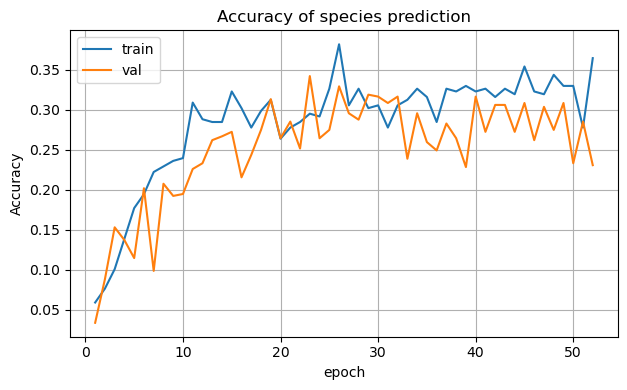

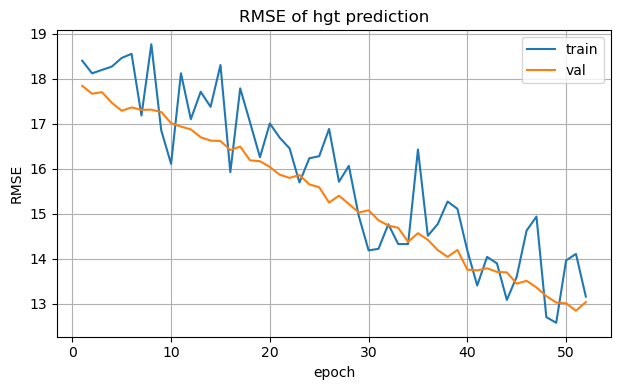

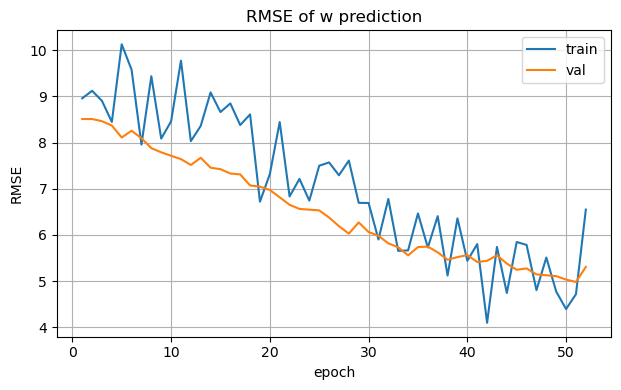

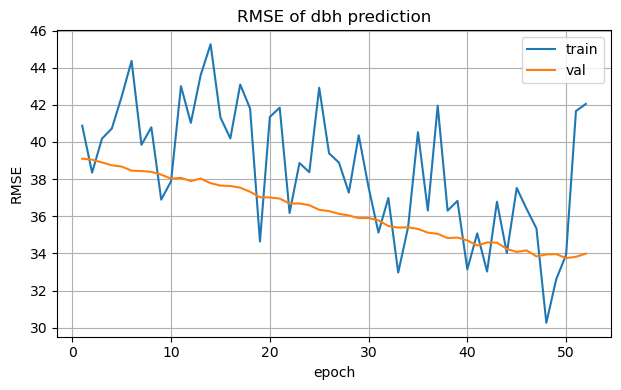

In [24]:
for i in range(len(results_df)):
    row = results_df.iloc[i]
    
    # plot_learning_process(row.train_clf_loss, row.val_clf_loss)
    plot_learning_process(row.train_latin_acc, row.val_latin_acc, "Accuracy of species prediction")
    plot_learning_process(row.train_hgt_RMSE, row.val_hgt_RMSE, "RMSE of hgt prediction")
    plot_learning_process(row.train_w_RMSE, row.val_w_RMSE, "RMSE of w prediction")
    plot_learning_process(row.train_dbh_RMSE, row.val_dbh_RMSE, "RMSE of dbh prediction")

In [25]:
test_dataset = TreeDatasetFromSubset(test, prepare_transform)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
)
test_loop(net, test_dataloader, loss_clf, loss_regr)

Batch #:   0%|          | 0/2 [00:00<?, ?it/s]

Validation accuracy: 26.7%, Validation loss: 756.636871 



{'val_loss': 756.6368713378906, 'val_acc': 0.2788461595773697}